<a href="https://colab.research.google.com/github/chhyyi/aiffel/blob/main/LMS/exp11_img_gen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

이것은 모두연/AIFFEL의 LMS Node입니다.
# EXP10 AI Fashion

>- Fahsion MNIST data 생성용 DCGAN 모델 구조를 이용,
- CIFAR-10 데이터를 생성하는 모델 직접 만들기  

>___달라지는 점___
- 이미지 데이터가 (28, 28, 1) -> (32, 32, 3)
- 전체 차원이 3~4배 증가? 이건 뭐  

Q) CIFAR-10 데이터가 무엇인가? 그 이미지 분류 10개 하는거였는데 MNIST는 숫자 쓰는거였고 기억이 가물가물하네.  
Q) fashion MNIST는 어디서 받는 거였지?

# (1) 작업 환경 구현



In [1]:
!pip3 install tensorflow==2.6.0
!pip3 install keras==2.6.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 564.4 MB 2.5 kB/s 
     |████████████████████████████████| 132 kB 6.9 MB/s 
     |████████████████████████████████| 14.8 MB 29.7 MB/s 
  Created wheel for clang: filename=clang-5.0-py3-none-any.whl size=30694 sha256=35a9357073bd9cca394edb829542787374836b246b65b6b04338b193f901ede9
  Stored in directory: /root/.cache/pip/wheels/98/91/04/971b4c587cf47ae952b108949b46926f426c02832d120a082a
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68721 sha256=3d46d9baeffa0920fa9abe45b6ce518e4360bf9bf3cbbdc96fea70cec5ed3a3b
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built clang wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Uninstalling typing-extensions-4.1.1:
      Successfully uninstalled typ

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 4.1 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0


In [1]:
!mkdir generated_samples
!mkdir training_checkpoints
!mkdir training_history

mkdir: cannot create directory ‘generated_samples’: File exists
mkdir: cannot create directory ‘training_checkpoints’: File exists
mkdir: cannot create directory ‘training_history’: File exists


In [1]:
import tensorflow as tf
import imageio
import numpy as np

cifar10 = tf.keras.datasets.cifar10



# (2). 데이터셋 구성
- 학습용 이미지를 (-1,1)범위로 정규화
- 시각화
- tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하여 미니배치 데이터셋 구성

In [2]:
(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape
print(train_x.shape)

train_x=2*(train_x/255)-1.0 #normalization as (-1,1)
print(np.min(train_x),np.max(train_x))

(50000, 32, 32, 3)
-1.0 1.0


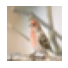

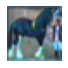

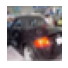

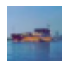

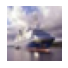

In [3]:
import matplotlib.pyplot as plt

for sample_index in np.random.choice(list(range(len(train_x))), 5):
    plt.figure(figsize=(1,1))
    plt.imshow(0.5+(train_x[sample_index])/2) #renormalize as 0~1.0
    plt.axis('off') #do not show axes
    plt.show()

__미니배치__ 라 함은 파라미터를 업데이트(학습)하는 단계에서 전체 데이터셋을 집어넣는 것이 아니라 일부만 넣어서 업데이트 하는 것임. tensorflow의 data.Dataset.shuffle, data.Dataset.from_tensor_slices 을 이용해서 해봅시다. 이걸 하면 tensorflow의 dataset이 됩니다. 근데 그게 뭘까요? 저는 tensor와 dataset을 혼동하고 있었던 것이 아닌가

In [4]:
mini_batch_size=100
buffer_size=1000
dataset=tf.data.Dataset.from_tensor_slices(train_x)
dataset.shuffle(buffer_size)
dataset=dataset.batch(mini_batch_size)

# (3) 생성자 모델 구현하기 

In [5]:
#copied from 11-9 and modified -> 이거 내용 이해가 잘 안됨
from tensorflow.keras import layers
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*3*256, use_bias=False, input_shape=(100,))) #image size : 32*32*3 / input_shape = (mini_batch_size,)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 3*256))) #we have 8*8*3*256 neuron at previous output. Does it contain any information about channel? or these features are indistinguishable from depth?


    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(256, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [6]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 49152)             4915200   
_________________________________________________________________
batch_normalization (BatchNo (None, 49152)             196608    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 49152)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 768)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 256)         4915200   
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 256)         1024      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 256)         0

In [7]:
noise = tf.random.normal([1, 100])

(1, 32, 32, 3)


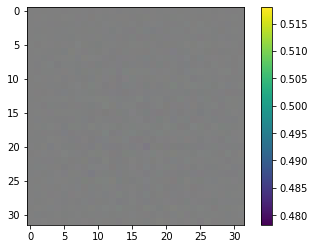

In [8]:
generated_image = generator(noise, training=False)
print(generated_image.shape)

plt.imshow((generated_image[0, :, :, :]/2)+0.5)
plt.colorbar()
plt.show()

In [9]:
print(np.min(generated_image), np.max(generated_image))

-0.043505132 0.035963945


# (4) 비평가 구현하기

In [10]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [11]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

In [12]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00058438]], dtype=float32)>

# (5) 손실함수와 최적화 함수 구현하기
>- 생성자와 판별자의 손실함수(loss)를 구현해 봅시다.
- 판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수를 구현해 봅시다.
- 생성자와 판별자를 최적화하는 optimizer를 정의합니다.

In [13]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [14]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

# (6) 훈련 과정 상세 기능 구현하기
>- 1개 미니배치의 훈련 과정을 처리하는 train_step() 함수를 구현해 봅시다.
- 16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images() 함수를 구현해 봅시다.
- 훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화하는 draw_train_history() 함수를 구현해 봅시다.
- training_checkpoints 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈을 설정해 봅시다.

In [15]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [32]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)
    #print('max is {} and min is {} of prediction'.format(np.max(predictions),np.min(predictions)))
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i, :, :, :]/2)+0.5) #renormalize as 0~1.0
        plt.axis('off')
   
    plt.savefig('./generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(epoch, it))

    plt.show()

In [35]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('./training_history/train_history_{:04d}.png'
                    .format(epoch))
    plt.show()

In [18]:
import os
checkpoint_dir = 'training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# (6)훈련과정 상세 기능 구현하기
>- 위 STEP 5에서 구현한 기능들을 활용하여 최소 50 epoch만큼의 모델 학습을 진행해 봅시다.
- 학습 과정에서 생성된 샘플 이미지로 만든 gif 파일을 통해 학습 진행 과정을 시각적으로 표현해 봅시다.
- 학습 과정을 담은 샘플 이미지, gif 파일, 학습 진행 그래프 이미지를 함께 제출합니다.

In [19]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [23]:
save_every = 20
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

from time import time
import time
import IPython.display as display
BATCH_SIZE=100

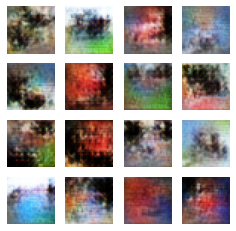

Time for training : 1005 sec


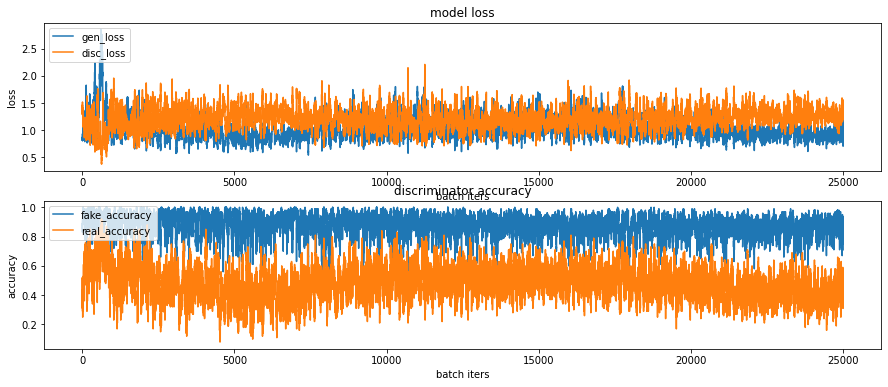

CPU times: user 17min 8s, sys: 19 s, total: 17min 27s
Wall time: 16min 47s


In [36]:
%%time
train(dataset, EPOCHS, save_every)

# move results to google drive



In [57]:
#path=r'/content/drive/MyDrive/colabdata/modulabs/lms_exp11/generated_samples/'

!cp -r '/content/generated_samples/' '/content/drive/MyDrive/colabdata/modulabs/lms_exp11/generated_samples/'

In [58]:
!cp -r '/content/training_checkpoints/' '/content/drive/MyDrive/colabdata/modulabs/lms_exp11/training_checkpoints/'
!cp -r '/content/training_history/' '/content/drive/MyDrive/colabdata/modulabs/lms_exp11/training_history/'

In [61]:
png_dir = '/content/generated_samples/'
images = []
for file_name in sorted(os.listdir(png_dir)):
    if file_name.endswith('.png'):
        file_path = os.path.join(png_dir, file_name)
        images.append(imageio.imread(file_path))
imageio.mimsave('/content/drive/MyDrive/colabdata/modulabs/lms_exp11/first.gif', images)

[animated gif](/content/drive/MyDrive/colabdata/modulabs/lms_exp11/training_history/)


## 